In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

In [2]:
%%time
# Load data #
data=pd.read_csv("merged.csv")

#  Print columns of dataset with missing values #
list = data.columns[data.isna().any()].tolist()
print(list)

# Fill NA values with mean of the corresponding column #
for i in list:
    print(i)
    print(data.isna().sum())                      
    data[i].fillna(data[i].mean(), inplace=True)  

[]
Wall time: 13.3 s


In [3]:
# Set feature and target columns #
features = data.drop(['step','labels'], axis=1)
target = data['labels']
#print(features.head(n=5))
#print(target.head(n=5))

# Open the list of featurenames for screening # 
list = np.loadtxt("NNfeaturelist.csv", dtype=str, delimiter=",")
screened = features[list]
#print(screened)

# Train test split and scale data #
XN1,XN2,yn1,yn2=train_test_split(screened, target, stratify=target, test_size =0.30, random_state=42)
scaler = StandardScaler()
xn1 = pd.DataFrame(scaler.fit_transform(XN1),columns = screened.columns)                       
xn2 = pd.DataFrame(scaler.transform(XN2),columns = screened.columns)

# To perform cross validation on train set #
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  

In [4]:
# BASE MODEL EVALUATION #
MLP = MLPClassifier
# Adjust the hidden_layer_sizes parameter to control the number of hidden layers and number of hidden neurons#
# In the current project, MLP1H = hidden_layer_sizes=(800,); MLP2H = hidden_layer_sizes=(800,400,); MLP3H = hidden_layer_sizes=(800,400,200,) #
base_new_model = MLP(hidden_layer_sizes=(800,),activation = 'relu', solver = 'adam', random_state=19)

accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []

# Model evaluation for cross validation on TRAINING DATASET # 

for train_index, test_index in cv.split(xn1,yn1):
    X_train, X_test = xn1.iloc[train_index], xn1.iloc[test_index]
    y_train, y_test = yn1.iloc[train_index], yn1.iloc[test_index]
    base_new_model.fit(X_train, y_train)
    y_pred = base_new_model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    
    accuracy_scores.append(acc)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    specificity_scores.append(specificity)
    
avg_acc=np.mean(accuracy_scores)
avg_f1=np.mean(f1_scores)
avg_precision=np.mean(precision_scores)
avg_recall=np.mean(recall_scores)
avg_specificity=np.mean(specificity_scores)

scoredata = pd.DataFrame()
valscoredict = {'Data':'Validation','score_accuracy':avg_acc,'score_f1':avg_f1,'score_precision':avg_precision,'score_recall':avg_recall, 'score_specificity': avg_specificity}
scoredata=scoredata.append(valscoredict, ignore_index = True)
#print(scoredata)

# Model evaluation on TEST DATASET 
base_new_model.fit(xn1, yn1)
y2_base_predict = pd.Series(base_new_model.predict(xn2))

base_test_accuracy = accuracy_score(yn2, y2_base_predict)
base_test_f1 = f1_score(yn2, y2_base_predict)
base_test_precision = precision_score(yn2, y2_base_predict)
base_test_recall = recall_score(yn2, y2_base_predict)
base_test_specificity = cm[0,0]/(cm[0,0]+cm[0,1])

testscoredict = {'Data':'Test','score_accuracy':base_test_accuracy,'score_f1':base_test_f1,'score_precision':base_test_precision,'score_recall':base_test_recall, 'score_specificity': base_test_specificity}
scoredata=scoredata.append(testscoredict, ignore_index = True)
#print(scoredata)

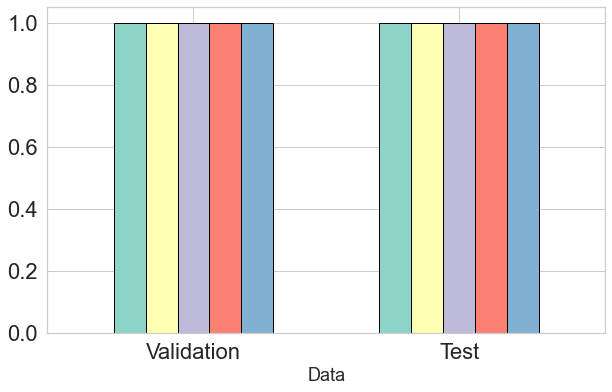

In [5]:
## PLOTS for BASE MODEL ##
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

# Plot classification scores #
c = plt.get_cmap('Set3')
sns.set_style("whitegrid")
scoredata.plot.bar(x="Data", rot=0, width=0.6, figsize=(10,6), fontsize=22, legend=False, edgecolor="black", linewidth=1, color = c.colors)
#plt.savefig("scaled/MLP-output/MLPbasemodel-scores-barplot-afterprescreen-split42.png", dpi=300)
plt.show()
plt.close()

In [6]:
# Print the pairs of neuron layers between which connection weights exist #
# Each pair element has two values x = no. of neurons in previous layer, y = no. of neurons in next layer #
# Each pair element has an array of x * y weights i.e. y weights for each x #

print([coef.shape for coef in base_new_model.coefs_]) 

[(1225, 800), (800, 1)]


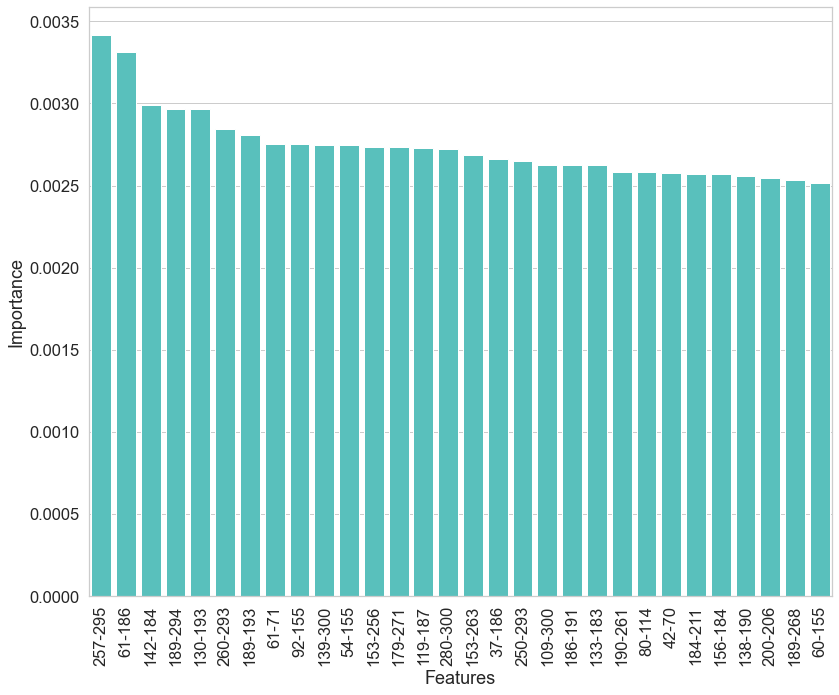

In [8]:
# Compute the absolute mean value of weights of each input to all neurons in next (hidden) layer # 
cols = xn1.columns.tolist()
featurelist = pd.DataFrame({"Features": cols})

mean_coefs= pd.DataFrame([np.abs(i.mean()) for i in base_new_model.coefs_[0]]) # average of all 'i' weights for each neuron # 
featurelist["Importance"]= mean_coefs
featurelist=featurelist.sort_values(by='Importance', ascending=False).reset_index(drop=True) 
#print(featurelist)

cumsum = pd.Series(featurelist["Importance"].cumsum(), name="Cumulative")
merged = pd.DataFrame(pd.concat([featurelist, cumsum], axis=1), index=None)
#merged.to_csv("scaled/MLP-output/MLPfeaturerank42.csv", sep=",")

# Print only top 30 features #
top30 = merged.iloc[:30] 
#top30.to_csv("scaled/MLP-output/MLPfeaturestop30.csv", sep=",")

# Plot feature importance values #
fig=plt.figure(figsize=(12, 10))
topres=merged.iloc[:30]   
sns.barplot(x=topres['Features'], y=topres['Importance'], color="mediumturquoise")
plt.xticks(rotation='vertical')
plt.tight_layout()
#plt.savefig("scaled/MLP-output/featurerank.png", dpi=300)